In [17]:
from lxml import etree
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from os import listdir
from os.path import isfile, join
from random import randint
import socket

hostname=socket.gethostname()

In [6]:
!ls /part/data/upairdrone

fils  labels  my_archive  rename.sh  serial  upairtag


In [103]:
if hostname=="te400":
    ## Dataset Directory - 
    ##  dir   -+-- training  -+- plastic
    ##         |              |- noplastic
    ##         |
    ##         +-- validation-+- plastic
    ##                        |- noplastic
    save_dir="/part/data/dataset/data.v3/"
    
    # Annotation Directory
    anno_dir="/part/data/upairdrone/labels/"
    
    # Aerial Imagery
    mypath="/part/data/upairdrone/upairtag/"
    
    # Trash Repository
    trashpath="/repo/trashnet-dataset/trashdata/plastic/"

else:
    
    save_dir="/media/winpart/dataset/data.v1/train/plastic/"
    anno_dir="/media/winpart/drone/labels/"
    mypath="/media/winpart/drone/upairtag/"
print(save_dir)

/part/data/dataset/data.v3/


In [20]:
## get image information from xml annotations (labelImg)
## showimages with 20 border all round

def show_pic_in_box(filename,xmin,xmax,ymin,ymax):
    print(filename,xmax-xmin+40,ymax-ymin+40)
    img = cv2.imread(filename)
    h,w,chan = img.shape
        
    dpi = 80
    xmin=min(max(0,int((xmax+xmin)/2-112)),w-224)
    ymin=min(max(0,int((ymax+ymin)/2-112)),h-224)
    xmax=xmin+224
    ymax=ymin+224
    print(xmin,ymin,xmax,ymax)
    crop_img = img[ymin:ymax, xmin:xmax]
    gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)

    figsize = (xmax-xmin) / float(dpi), (ymax-ymin) / float(dpi)
    fig = plt.figure(figsize=figsize)

    plt.imshow(gray)
    plt.title('my picture')
    plt.show()

In [21]:
# Get a list of width and height values for statistics
widths=[]
heights=[]
def pic_statistics(filename,xmin,xmax,ymin,ymax):
    global widths,heights
    
    widths.append(xmax-xmin)
    heights.append(ymax-ymin)


In [31]:
file_serial=0
def crop_and_save(img,x,y,traindir):
    global file_serial,save_dir
    
    ymin=y-112
    ymax=ymin+224
    xmin=x-112
    xmax=xmin+224
    
    crop_img = img[ymin:ymax, xmin:xmax]
    
    if traindir==False:
        savefile=save_dir+"train/plastic/"+str(file_serial).zfill(3)+".jpg"
    else:
        savefile=save_dir+"validation/plastic/"+str(file_serial).zfill(3)+".jpg"
        
    file_serial=file_serial+1    
    cv2.imwrite(savefile,crop_img)

In [32]:
## get image information from xml annotations (labelImg)

def save_pic_in_box(filename,xmin,xmax,ymin,ymax,shift=False, traindir=True):
    
    filename=mypath+filename
    
    img = cv2.imread(filename)
    h,w,chan = img.shape
        
    dpi = 80
    cx=int((xmax+xmin)/2)
    cy=int((ymax+ymin)/2)
    crop_and_save(img, cx,cy,traindir=traindir)
    
    if shift==True:
        crop_and_save(img, cx-56,cy-56,traindir=traindir)
        crop_and_save(img, cx-56,cy   ,traindir=traindir)
        crop_and_save(img, cx-56,cy+56,traindir=traindir)
        crop_and_save(img, cx   ,cy-56,traindir=traindir)
        crop_and_save(img, cx   ,cy+56,traindir=traindir)
        crop_and_save(img, cx+56,cy-56,traindir=traindir)
        crop_and_save(img, cx+56,cy   ,traindir=traindir)
        crop_and_save(img, cx+56,cy+56,traindir=traindir)


In [35]:
## Capture bounding box data from annotation xml
## Automatically update statistics
## Option 1: show pics
## Option 2: write files to /repo/trainimgs

def getboxes_in_xml(xmlfilename,option):
    context = etree.iterparse(xmlfilename)
    bndbox=0
    
    # Cross Validation on Random 70 training and 30% validation
    crossvalidationshuffle=randint(0,100)<30
    
    for action, elem in context:
        if elem.tag=="bndbox":
            bndbox=bndbox+1

        if elem.text:
            if elem.tag=="filename":
                filename=elem.text
            if elem.tag=="xmin":
                xmin=int(elem.text)
            if elem.tag=="ymin":
                ymin=int(elem.text)
            if elem.tag=="xmax":
                xmax=int(elem.text)
            if elem.tag=="ymax":
                ymax=int(elem.text)
                pic_statistics(filename,xmin,xmax,ymin,ymax)
                if option==1:
                    show_pic_in_box(filename,xmin,xmax,ymin,ymax)
                if option==2:
                    save_pic_in_box(filename,xmin,xmax,ymin,ymax,shift=True,traindir=crossvalidationshuffle)


In [36]:
## Goto /repo/annotations
## list xml files
## get information from files

onlyfiles = [f for f in listdir(anno_dir) if isfile(join(anno_dir, f))]
print("Number of files: "+str(len(onlyfiles)))
for xmlfiles in onlyfiles:
    getboxes_in_xml(anno_dir+"/"+xmlfiles,2)


Number of files: 181


Text(0.5,1,'Picture Height')

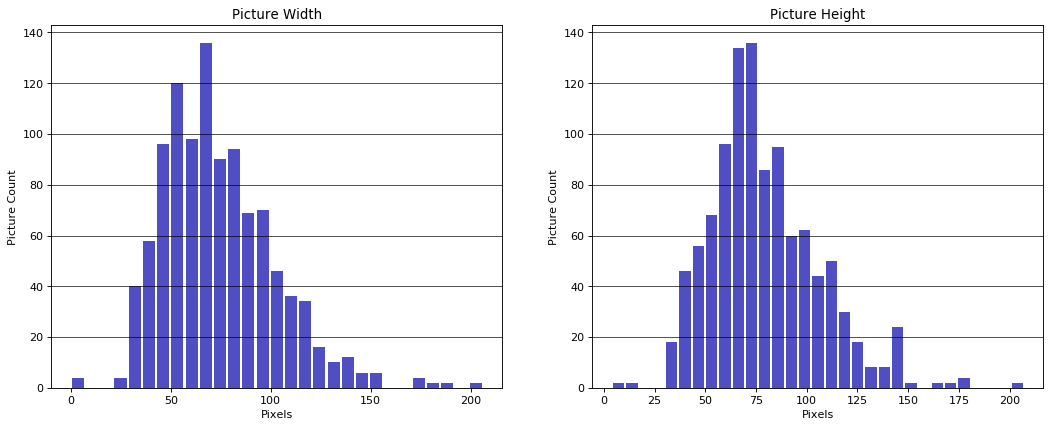

In [37]:
# fixed bin size
data=widths
bins = np.arange(0, 90, 5) # fixed bin size
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(x=widths, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75,color="black")
plt.xlabel('Pixels')
plt.ylabel('Picture Count')
plt.title('Picture Width')

plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(x=heights, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75,color="black")
plt.xlabel('Pixels')
plt.ylabel('Picture Count')
plt.title('Picture Height')


## Background images taken from Aerial Imagery

- Used boundingboxes to eliminate possible plastic in background
- Image tiles in 5x3 and a random located 224x224 image within each tile is taked
- 70 % 30 % put in training / validation

In [93]:
file_serial=0
def back_crop_and_save(img,x,y,traindir):
    global file_serial,save_dir
    
    ymin=y-112
    ymax=ymin+224
    xmin=x-112
    xmax=xmin+224
    
    crop_img = img[ymin:ymax, xmin:xmax]
    
    if traindir==False:
        savefile=save_dir+"train/noplastic/"+str(file_serial).zfill(3)+".jpg"
    else:
        savefile=save_dir+"validation/noplastic/"+str(file_serial).zfill(3)+".jpg"
        
    file_serial=file_serial+1    
    cv2.imwrite(savefile,crop_img)  

In [94]:
def saverandom_with_avoidance(filename,avoid_list,traindir):
    ## get random co-ordinates from image tiled in 5x3 grid
    filename=mypath+filename
    print(filename)
    
    img = cv2.imread(filename)
    h,w,chan = img.shape
    
    for dy in range(3):
        for dx in range(5):
            hit=True
            while hit==True:
                hit=False
                
                cx=randint(112,round(((w-112)/5)+int(dx*w/5)))
                cy=randint(112,round(((h-112)/5)+int(dy*h/3)))
                for avoidcoord in avoid_list:
                    bx,by=avoidcoord
                    if bx>(cx-112) and bx<(cx+112):
                        if by>(cy-112) and by<(cy+112):
                            hit=True

            back_crop_and_save(img, cx,cy,traindir=traindir)
    

In [95]:
def getboxcentres(xmlfile):
    context = etree.iterparse(xmlfile)
    bndbox=0
    
    # Cross Validation on Random 70 training and 30% validation
    crossvalidationshuffle=randint(0,100)<30
    bounding_box=[]
    
    for action, elem in context:
        if elem.tag=="bndbox":
            bndbox=bndbox+1

        if elem.text:
            if elem.tag=="xmin":
                xmin=int(elem.text)
            if elem.tag=="ymin":
                ymin=int(elem.text)
            if elem.tag=="xmax":
                xmax=int(elem.text)
            if elem.tag=="ymax":
                ymax=int(elem.text)
                bounding_box.append([round((xmin+xmax)/2),round((ymin+ymax)/2)])
    return bounding_box


In [96]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
xmlfiles = [f for f in listdir(anno_dir) if isfile(join(anno_dir, f))]
print("Number of files: "+str(len(onlyfiles)))
for imagefiles in onlyfiles:
    xmlfile=imagefiles.split(".")[0]+".xml"
    avoidlist=[]
    if xmlfile in xmlfiles:
        avoidlist=getboxcentres(anno_dir+xmlfile)
        
    saverandom_with_avoidance(imagefiles,avoidlist,randint(0,100)<30)


Number of files: 394
/part/data/upairdrone/upairtag/1166.jpg
/part/data/upairdrone/upairtag/1010.jpg
/part/data/upairdrone/upairtag/1248.jpg
/part/data/upairdrone/upairtag/1118.jpg
/part/data/upairdrone/upairtag/1088.jpg
/part/data/upairdrone/upairtag/1333.jpg
/part/data/upairdrone/upairtag/1070.jpg
/part/data/upairdrone/upairtag/1198.jpg
/part/data/upairdrone/upairtag/1350.jpg
/part/data/upairdrone/upairtag/1214.jpg
/part/data/upairdrone/upairtag/1328.jpg
/part/data/upairdrone/upairtag/1080.jpg
/part/data/upairdrone/upairtag/1126.jpg
/part/data/upairdrone/upairtag/1148.jpg
/part/data/upairdrone/upairtag/1370.jpg
/part/data/upairdrone/upairtag/1024.jpg
/part/data/upairdrone/upairtag/1204.jpg
/part/data/upairdrone/upairtag/1210.jpg
/part/data/upairdrone/upairtag/1162.jpg
/part/data/upairdrone/upairtag/1260.jpg
/part/data/upairdrone/upairtag/1303.jpg
/part/data/upairdrone/upairtag/1338.jpg
/part/data/upairdrone/upairtag/1237.jpg
/part/data/upairdrone/upairtag/1247.jpg
/part/data/upairdro

/part/data/upairdrone/upairtag/1344.jpg
/part/data/upairdrone/upairtag/1301.jpg
/part/data/upairdrone/upairtag/1023.jpg
/part/data/upairdrone/upairtag/1144.jpg
/part/data/upairdrone/upairtag/1040.jpg
/part/data/upairdrone/upairtag/1121.jpg
/part/data/upairdrone/upairtag/1155.jpg
/part/data/upairdrone/upairtag/1312.jpg
/part/data/upairdrone/upairtag/1062.jpg
/part/data/upairdrone/upairtag/1219.jpg
/part/data/upairdrone/upairtag/1307.jpg
/part/data/upairdrone/upairtag/1114.jpg
/part/data/upairdrone/upairtag/1104.jpg
/part/data/upairdrone/upairtag/1236.jpg
/part/data/upairdrone/upairtag/1178.jpg
/part/data/upairdrone/upairtag/1361.jpg
/part/data/upairdrone/upairtag/1295.jpg
/part/data/upairdrone/upairtag/1347.jpg
/part/data/upairdrone/upairtag/1073.jpg
/part/data/upairdrone/upairtag/1329.jpg
/part/data/upairdrone/upairtag/1187.jpg
/part/data/upairdrone/upairtag/1283.jpg
/part/data/upairdrone/upairtag/1235.jpg
/part/data/upairdrone/upairtag/1384.jpg
/part/data/upairdrone/upairtag/1364.jpg


### From Trashnet dataset

- Taken files rescaled them to 224x224
- Only used as Training images Plastic

In [106]:
from PIL import Image

onlyfiles = [f for f in listdir(trashpath) if isfile(join(trashpath, f))]
file_serial=0
for i in onlyfiles:
    filename=trashpath+i
    
    img = Image.open(filename).resize( (224,224) )
    
    out = save_dir+"train/plastic/"+str(file_serial).zfill(5)+".jpg"
    file_serial=file_serial+1
    try:
        img.save(out, "JPEG")
    finally:
        img.close()

'/repo/trashnet-dataset/trashdata'